## Problem Statement
 The goal of this project is to develop a Spam-Ham Detection Model that can classify incoming messages as either spam
 or ham

## Target Column
The target column in this dataset is "label", where:

0 → Ham (legitimate message)

1 → Spam (unwanted message)

In [5]:
# 1️Import Necessary Libraries

# Standard Libraries
import pandas as pd
import numpy as np
import string
import re

# Natural Language Processing (NLP) Libraries
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer

# Feature Extraction & Machine Learning
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

# Handle Imbalanced Data
from imblearn.over_sampling import SMOTE

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns

# Ensure necessary NLTK resources are available
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ADMIN\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [6]:
# Load dataset
data= pd.read_csv(r"C:\Users\ADMIN\Downloads\IT vedant\Machine Learning\ML Project\spam.csv", encoding='latin1')
data.head()

,v1,v2,Unnamed: 2,Unnamed: 3,Unnamed: 4
0,ham,"Go until jurong point, crazy.. Available only ...",NaN,NaN,NaN
1,ham,Ok lar... Joking wif u oni...,NaN,NaN,NaN
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,NaN,NaN,NaN
3,ham,U dun say so early hor... U c already then say...,NaN,NaN,NaN
4,ham,"Nah I don't think he goes to usf, he lives aro...",NaN,NaN,NaN


In [7]:
df=data.copy()

In [8]:
# Drop unnecessary columns and rename useful ones
# The dataset may have unnecessary columns, so we only keep relevant ones.
df=df[['v1', 'v2']].rename(columns={'v1': 'label', 'v2': 'message'})

In [9]:
df.head()

,label,message
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [10]:
# Convert categorical labels to binary values
# 'ham' (not spam) is converted to 0, and 'spam' is converted to 1
df['label']=df['label'].map({'ham': 0, 'spam': 1})

In [11]:
## check missing values
df.isnull().sum()

label      0
message    0
dtype: int64

In [12]:
# Remove duplicate messages to avoid biased training
df.drop_duplicates(inplace=True)
df.duplicated().sum()

0

## EDA

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')

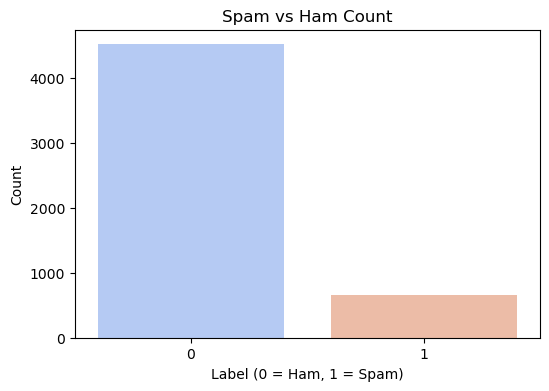

In [15]:
# Distribution of target variable
# Visualizing the distribution of spam vs. ham messages
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=df, palette='coolwarm')
plt.title("Spam vs Ham Count")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Count")
plt.show()

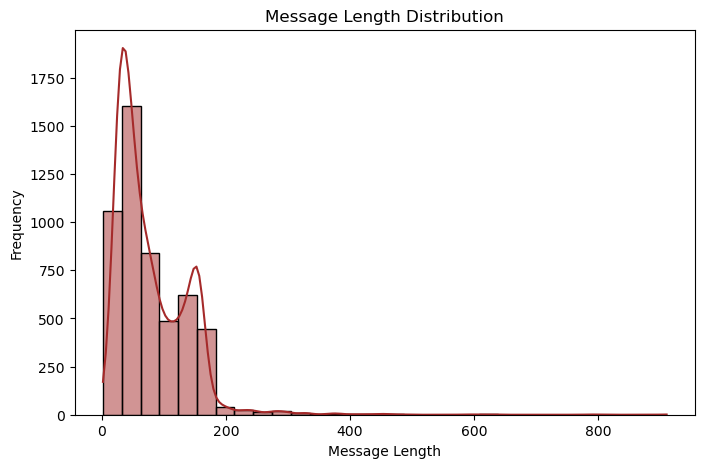

In [16]:
# Analyzing the distribution of message lengths
df['message_length'] = df['message'].apply(len)  # Calculate the length of each message
plt.figure(figsize=(8, 5))
sns.histplot(df['message_length'], bins=30, kde=True, color='brown')
plt.title("Message Length Distribution")
plt.xlabel("Message Length")
plt.ylabel("Frequency")
plt.show()

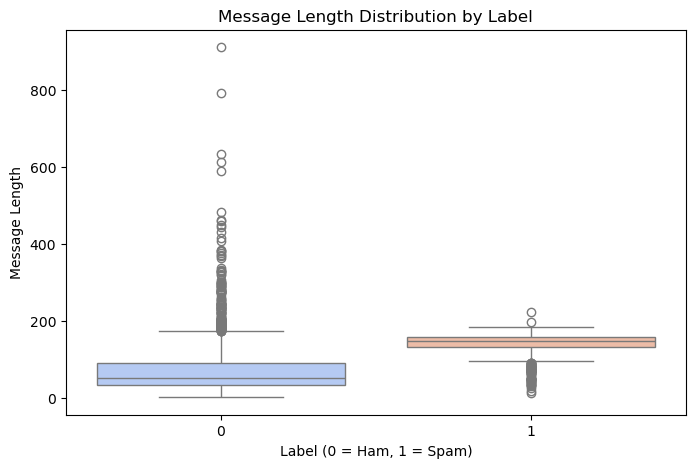

In [17]:
# Box plot to analyze message length by label
plt.figure(figsize=(8, 5))
sns.boxplot(x='label', y='message_length', data=df, palette='coolwarm')
plt.title("Message Length Distribution by Label")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Message Length")
plt.show()

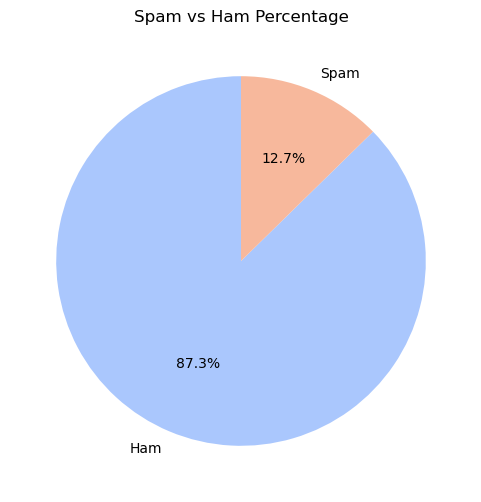

In [18]:
# Pie chart to visualize spam vs. ham ratio
plt.figure(figsize=(6, 6))
labels = ['Ham', 'Spam']
colors = sns.color_palette("coolwarm", 2)  # Uses the 'coolwarm' color palette from Seaborn
df['label'].value_counts().plot.pie(autopct='%1.1f%%', labels=labels, colors=colors, startangle=90)
plt.title("Spam vs Ham Percentage")
plt.ylabel("")
plt.show()


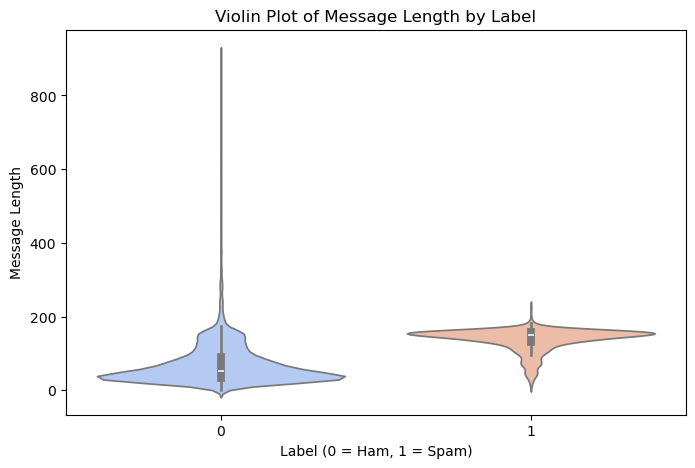

In [19]:
# Violin plot to visualize message length distribution by label
plt.figure(figsize=(8, 5))
sns.violinplot(x='label', y='message_length', data=df, palette='coolwarm')
plt.title("Violin Plot of Message Length by Label")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Message Length")
plt.show()

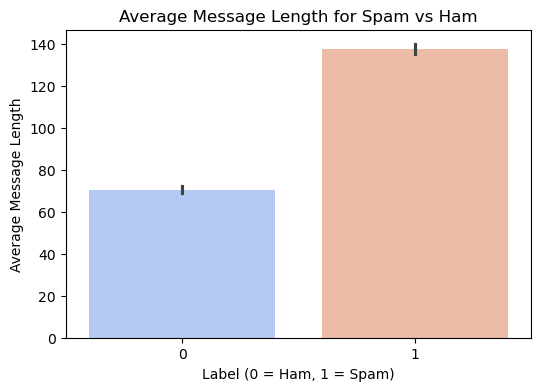

In [20]:
# Bar plot of the average message length for spam vs. ham
plt.figure(figsize=(6, 4))
sns.barplot(x=df['label'], y=df['message_length'], estimator=lambda x: x.mean(), palette="coolwarm")
plt.title("Average Message Length for Spam vs Ham")
plt.xlabel("Label (0 = Ham, 1 = Spam)")
plt.ylabel("Average Message Length")
plt.xticks(rotation=0)
plt.show()

## Model Building

In [27]:
 # Text Preprocessing Function
def preprocess_text(text):
    """Function to clean and preprocess text data"""
    text = text.lower()  # Convert to lowercase
    text = re.sub(r'\d+', '', text)  # Remove numbers
    text = text.translate(str.maketrans('', '', string.punctuation))  # Remove punctuation
    tokens = word_tokenize(text)  # Tokenize words
    tokens = [word for word in tokens if word not in stopwords.words('english')]  # Remove stopwords
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]  # Apply lemmatization
    return " ".join(tokens)

In [ ]:
# Apply text preprocessing
df['message'] = df['message'].apply(preprocess_text)
print("Text Preprocessing Completed!")

In [ ]:
#  Feature Extraction using TF-IDF
vectorizer = TfidfVectorizer(max_features=5000)
X_tfidf = vectorizer.fit_transform(df['message'])

In [ ]:
# Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X_tfidf, df['label'], test_size=0.2, random_state=42, stratify=df['label'])

In [ ]:
# Handle Class Imbalance using SMOTE
smote = SMOTE(random_state=42)
X_train_resampled, y_train_resampled = smote.fit_resample(X_train, y_train)

print(f"Original Class Distribution:\n{pd.Series(y_train).value_counts()}")
print(f"Resampled Class Distribution:\n{pd.Series(y_train_resampled).value_counts()}")


In [ ]:
#  Train Multiple Machine Learning Models
models = {
    "Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(max_iter=1000),
    "Support Vector Machine": SVC(kernel='linear', probability=True),
    "Decision Tree": DecisionTreeClassifier(),
    "Random Forest": RandomForestClassifier(n_estimators=100),
    "Gradient Boosting": GradientBoostingClassifier(),
    "K-Nearest Neighbors": KNeighborsClassifier()
}


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, confusion_matrix

In [ ]:
# Store results
results = []

In [ ]:
# Train and evaluate each model
for name, model in models.items():
    try:
        print(f"\nTraining {name}...")

        # Train the model
        model.fit(X_train_resampled, y_train_resampled)

        # Predictions on Training Data
        y_pred_train = model.predict(X_train_resampled)
        train_acc = accuracy_score(y_train_resampled, y_pred_train)

        # Predictions on Test Data
        y_pred_test = model.predict(X_test)
        test_acc = accuracy_score(y_test, y_pred_test)

        # Classification Report & Confusion Matrix
        class_report = classification_report(y_test, y_pred_test)
        conf_matrix = confusion_matrix(y_test, y_pred_test)

        # Append a dictionary to the list
        results.append({
            "Model": name,
            "Training Accuracy": train_acc,
            "Testing Accuracy": test_acc,
            "Precision": precision_score(y_test, y_pred_test),
            "Recall": recall_score(y_test, y_pred_test),
            "F1-Score": f1_score(y_test, y_pred_test)
        })

        # Print detailed performance
        print(f"Training Accuracy: {train_acc:.4f}")
        print(f"Testing Accuracy: {test_acc:.4f}")
        print("Classification Report:\n", class_report)
        print("Confusion Matrix:\n", conf_matrix)
        print("-" * 50)  # Separator line

    except Exception as e:
        print(f"Error training {name}: {e}")

# Convert results to DataFrame
results_df = pd.DataFrame(results)

# Display the performance of all models
print("\nModel Performance Summary:\n")
print(results_df.sort_values(by="Testing Accuracy", ascending=False))

In [ ]:
# Convert results list into a Pandas DataFrame
results_df = pd.DataFrame(results)

In [ ]:
# Plot model performance
plt.figure(figsize=(10, 5))
sns.barplot(x=results_df["Model"], y=results_df["Testing Accuracy"], palette='coolwarm')
plt.xticks(rotation=45)
plt.xlabel("Classification Models")
plt.ylabel("Testing Accuracy")
plt.title("Model Performance Comparison")
plt.show()

## Deployment

In [ ]:
# Train Random Forest Model
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_resampled, y_train_resampled)

# Save the trained Random Forest model
with open("random_forest_model.pkl", "wb") as model_file:
    pickle.dump(rf_model, model_file)

# Save the vectorizer
with open("vectorizer.pkl", "wb") as vec_file:
    pickle.dump(vectorizer, vec_file)

print("Random Forest model and vectorizer saved successfully!")

In [ ]:
# !pip install streamlit

In [ ]:
!python -m streamlit run "C:\Users\ADMIN\Downloads\IT vedant\Machine Learning\ML Project\app.py"